In [ ]:
#!pip install pulser

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser.waveforms import ConstantWaveform, InterpolatedWaveform
from pulser.devices import Chadoq2
from scipy.optimize import minimize
from pulser_simulation import QutipEmulator
from scipy.spatial.distance import pdist, squareform


/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [ ]:
np.random.seed(42)

# Define the number of variables (N), the weights (Wij), and the constant (C)
N = 10
distances = np.random.randint(1, 100, size=(N, N))
np.fill_diagonal(distances, 0)
Wij = distances
C = N / 2

# Define the objective function to be minimized
def objective(x):
    Q = np.zeros((N, N))
    for i in range(N):
        for j in range(i + 1, N):
            Q[i, j] = Wij[i, j]

    Qii = -np.sum(Q, axis=1) + 1 - N
    for i in range(N):
        Q[i, i] = Qii[i]

    return np.sum(Q)

# Define the equality constraint
def constraint(x):
    return np.sum(x) - C

# Define the bounds for the variables (0 <= Xi <= 1)
bounds = [(0, 1)] * N

# Initial guess
x0 = np.zeros(N)

# Set up the optimization problem
constraints = {'type': 'eq', 'fun': constraint}
result = minimize(objective, x0, method='SLSQP', constraints=constraints, bounds=bounds)

# Calculate Q matrix after obtaining the optimal solution
optimal_solution = result.x
optimal_solution = result.x
Q_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(i + 1, N):
        Q_matrix[i, j] = Wij[i, j] * optimal_solution[i] * optimal_solution[j]
        Q_matrix[j, i] = Q_matrix[i, j]  # Ensure symmetry

    # Calculate linear terms (Qii) based on the constant C and the quadratic terms
    Qii = -np.sum(Q_matrix, axis=1) + 1 - N
    for i in range(N):
        Q_matrix[i, i] = Qii[i]
    for i in range(N):
        Q_matrix[i, i] = Qii[i]

# Print the result
print("Optimal solution:")
print(optimal_solution)
print("Optimal objective value:", result.fun)
print("Q matrix:")
print(Q_matrix)


Optimal solution:
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Optimal objective value: -90.0
Q matrix:
[[ 1.42108547e-14  2.32500000e+01  3.75000000e+00  1.80000000e+01
   1.52500000e+01  5.25000000e+00  2.07500000e+01  2.17500000e+01
   1.87500000e+01  1.87500000e+01]
 [ 2.32500000e+01 -5.95000000e+01  7.50000000e-01  5.50000000e+00
   1.32500000e+01  5.00000000e-01  2.20000000e+01  7.50000000e+00
   9.50000000e+00  5.00000000e-01]
 [ 3.75000000e+00  7.50000000e-01 -7.50000000e-01  8.25000000e+00
   1.90000000e+01  1.45000000e+01  5.50000000e+00  2.22500000e+01
   1.22500000e+01  2.27500000e+01]
 [ 1.80000000e+01  5.50000000e+00  8.25000000e+00 -8.75000000e+01
   2.00000000e+01  3.75000000e+00  1.55000000e+01  1.55000000e+01
   1.17500000e+01  1.55000000e+01]
 [ 1.52500000e+01  1.32500000e+01  1.90000000e+01  2.00000000e+01
  -3.32500000e+01  1.75000000e+00  5.25000000e+00  1.82500000e+01
   9.75000000e+00  4.50000000e+00]
 [ 5.25000000e+00  5.00000000e-01  1.45000000e+01  3.75000000e+0

In [ ]:
#Now that we have the QUBO instance
Q = Q_matrix
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

[('0101010100', -192.99999999999994), ('0101010000', -189.4999999999999), ('0101010001', -172.9999999999999)]


In [ ]:
def evaluate_mapping(new_coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""
    Q, shape = args
    new_coords = np.reshape(new_coords, shape)
    new_Q = squareform(Chadoq2.interaction_coeff / pdist(new_coords) ** 6)
    return np.linalg.norm(new_Q - Q)

In [ ]:
shape = (len(Q), 2)
costs = []
np.random.seed(0)
x0 = np.random.random(shape).flatten()
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q, shape),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

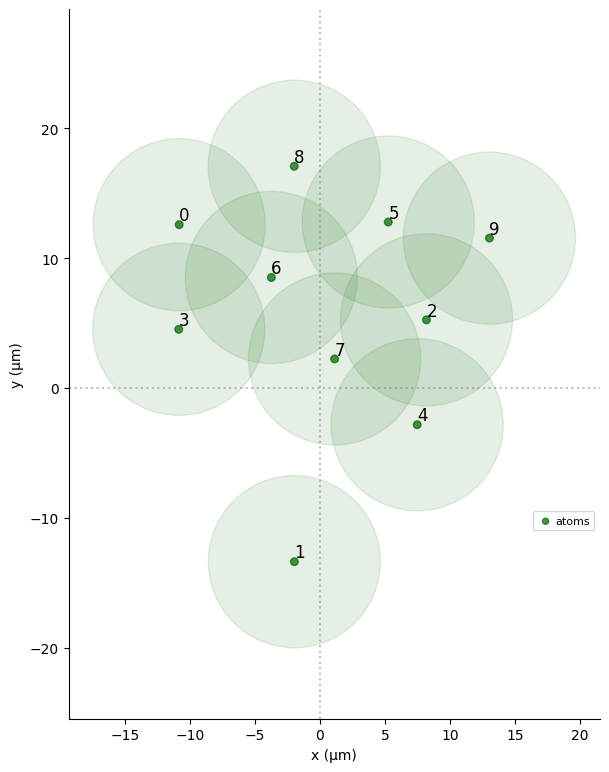

In [ ]:
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

In [ ]:
seq = Sequence(reg, Chadoq2)

seq.declare_channel("local1", "raman_local")
seq.declare_channel("local2", 'rydberg_local')
seq.declare_channel("global", 'rydberg_global')

seq.target(0,"local1")
seq.target(1,"local2")


# In[8]:


N = 10

#define local detuning
W = np.random.randint(1,11,N)
detuning = W

#rescale_detuing (set maximum detuing to be 100 minimum to be 0)
def rescale(w):
    xmin = np.min(w)
    xmax = np.max(w)
    rescaled_detun = [(w[i]-xmin)*100/(xmax-xmin) for i in range(len(w))]
    return rescaled_detun

rescaled_detuning = rescale(detuning)


# In[11]:


rescaled_detuning


# In[9]:


#duration of a pulse
duration = 40

#constant rabi pulse for 50ns 2rad/s and 0 detuning
rabi_simple_pulse = Pulse.ConstantPulse(duration, 2, 0, 0)


#a list of constant local detuning pulses
local_simple_pulse = [Pulse.ConstantPulse(duration, 0, rescaled_detuning[i], 0) for i in range(N)]

#Define number of trotterization
iteration = 32

trott = 0
while trott < iteration:
    trott += 1

    #Each trotterization starts with a global rabi drive
    seq.add(rabi_simple_pulse, "global")
    seq.delay(duration,"local1")
    seq.delay(duration,"local2")

    #A series of  local detuing
    for i in range(N//2):
        seq.target(2*i, "local1")
        seq.target(2*i+1, "local2")

        seq.add(local_simple_pulse[2*i], "local1",protocol="no-delay")
        seq.add(local_simple_pulse[2*i+1], "local2",protocol="no-delay")


    if N%2 != 0:
        seq.target(N-1,"local1")
        seq.target(0,"local2")
        seq.add(local_simple_pulse[N-1],"local1",protocol="no-delay")
        seq.add(Pulse.ConstantPulse(duration, 0, 0, 0),"local2")

seq.measure(basis="ground-rydberg")
serialized_sequence = seq.to_abstract_repr()

/usr/local/lib/python3.10/dist-packages/pulser/register/register.py:375: UserWarning: Register serialization to an abstract representation irreversibly converts all qubit ID's to strings.
  names = stringify_qubit_ids(self._ids)


In [ ]:
#!pip install pasqal-cloud

In [ ]:
from pasqal_cloud.device import EmulatorType
job1 = {"runs": 100}
job2 = {"runs": 500}
serialized_sequence = seq.to_abstract_repr()
batch = sdk.create_batch(
    serialized_sequence, [job1], emulator=EmulatorType.EMU_FREE
)

In [ ]:
for job in batch.ordered_jobs:
    print(f"job-id: {job.id}, status: {job.status}, result: {job.result}")

job-id: a3fb5ceb-286d-48f6-86bd-d5336c3b7498, status: PENDING, result: None
